**Basic Decision Tree Modeling For Bank Credit Dataset**


The selected dataset contains client data from a Portuguese bank's marketing campaign, aiming to predict whether a client will subscribe to a term deposit.

**Column Definitions:**


*   job:	Occupation
*   marital:	Marital status
*   education:	Education level
*   default:	Has credit in default? (yes/no)
*   balance:	Average yearly bank balance (in euros)
*   housing:	Has a housing loan? (yes/no)
*   loan:	Has a personal loan? (yes/no)
*   contact:	Contact communication type (cellular, telephone)
*   day:	Last contact day of the month
*   month:	Last contact month of the year
*   duration:	Duration of last contact in seconds
*   campaign:	Number of contacts during the current campaign
*   pdays:Days passed since last contact from a previous campaign (999 / -1 = no previous contact)
*  previous:	Number of contacts before this campaign
*  poutcome:	Outcome of the previous marketing campaign (success, failure, unknown)
*   target:	Has the client subscribed to a term deposit? (1 = no, 2 = yes)




In [33]:
# Import sklearn object

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

In [13]:
!pip install openml
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Access data with API Key
openml.config.apikey = 'd1d7d235b5af2860d5e4962ed225765e'

# Connect data
dataset = openml.datasets.get_dataset(1461)

# Construct dataFrame
data_tuple = dataset.get_data(target=dataset.default_target_attribute)

X = data_tuple[0]
y = data_tuple[1]
df = X.copy()

# Rename the columns
df.columns = [
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
    'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome'
]

df['target'] = y

# Check dataframe
print(df.head(5))

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no   2143.0     yes   no   
1   44    technician   single  secondary      no     29.0     yes   no   
2   33  entrepreneur  married  secondary      no      2.0     yes  yes   
3   47   blue-collar  married    unknown      no   1506.0     yes   no   
4   33       unknown   single    unknown      no      1.0      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome target  
0  unknown    5   may     261.0         1   -1.0       0.0  unknown      1  
1  unknown    5   may     151.0         1   -1.0       0.0  unknown      1  
2  unknown    5   may      76.0         1   -1.0       0.0  unknown      1  
3  unknown    5   may      92.0         1   -1.0       0.0  unknown      1  
4  unknown    5   may     198.0         1   -1.0       0.0  unknown      1  


In [14]:
# Check for null and dublicates values
print(df.isnull().sum())
print(df.duplicated().sum())

# Check data statistics
print(df.describe())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64
0
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

         

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  uint8   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  float64 
 4   default    45211 non-null  category
 5   balance    45211 non-null  float64 
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  uint8   
 10  month      45211 non-null  float64 
 11  duration   45211 non-null  float64 
 12  campaign   45211 non-null  uint8   
 13  previous   45211 non-null  float64 
 14  poutcome   45211 non-null  float64 
 15  target     5289 non-null   float64 
 16  pdays_cat  45211 non-null  float64 
dtypes: category(6), float64(8), uint8(3)
memory usage: 3.1 MB


In [16]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
  print(col,":", df[col].unique())

job : ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', ..., 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
Length: 12
Categories (12, object): ['admin.' < 'blue-collar' < 'entrepreneur' < 'housemaid' ... 'student' <
                          'technician' < 'unemployed' < 'unknown']
marital : ['married', 'single', 'divorced']
Categories (3, object): ['divorced' < 'married' < 'single']
education : ['tertiary', 'secondary', 'unknown', 'primary']
Categories (4, object): ['primary' < 'secondary' < 'tertiary' < 'unknown']
default : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
housing : ['yes', 'no']
Categories (2, object): ['no' < 'yes']
loan : ['no', 'yes']
Categories (2, object): ['no' < 'yes']
contact : ['unknown', 'cellular', 'telephone']
Categories (3, object): ['cellular' < 'telephone' < 'unknown']
month : ['may', 'jun', 'jul', 'aug', 'oct', ..., 'jan', 'feb', 'mar', 'apr', 'sep']
Length: 12
Categories (12, object): ['apr' < 'aug' < 'de

In [21]:
# Make target column binary regarding category values
df['target'] = df['target'].astype(str).str.strip()
df['target'] = df['target'].map({'1': 0, '2': 1})

df.target.unique()

array([nan,  0.])

In [20]:
# Converting pdays column into ordinal categories since it has mostly null values
print(df.pdays.isin([-1, 999]).sum())

def mapping_pdays(num):
    if num in [-1, 999]:
        return "no_contact"
    elif num <= 30:
        return "recent"
    elif num <= 90:
        return "1_3_months"
    else:
        return "over_3_months"

df['pdays_cat'] = df['pdays'].apply( mapping_pdays)
df = df.drop('pdays', axis=1)


# Filter ordinal categorical columns and determine order
ordinal_cols = ['education', 'month', 'poutcome','pdays_cat']
for x in ordinal_cols:
    df[x] = df[x].astype(str)
    df[x] = df[x].str.strip()

ordinal_order = [
    ['primary', 'secondary', 'tertiary', 'unknown'],
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    ['failure', 'other', 'success', 'unknown'],
    ['no_contact', 'recent', '1_3_months', 'over_3_months']
]

# Apply ordinal encoding
encoder = OrdinalEncoder(categories=ordinal_order)
df[ordinal_cols] = encoder.fit_transform(df[ordinal_cols])

# Converting non-numeric variables into numeric variables
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact']

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)


# Split features and target
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

AttributeError: 'DataFrame' object has no attribute 'pdays'

In [23]:
#Check y value distribution
print(y.value_counts(normalize=True))

target
0    0.883015
1    0.116985
Name: proportion, dtype: float64


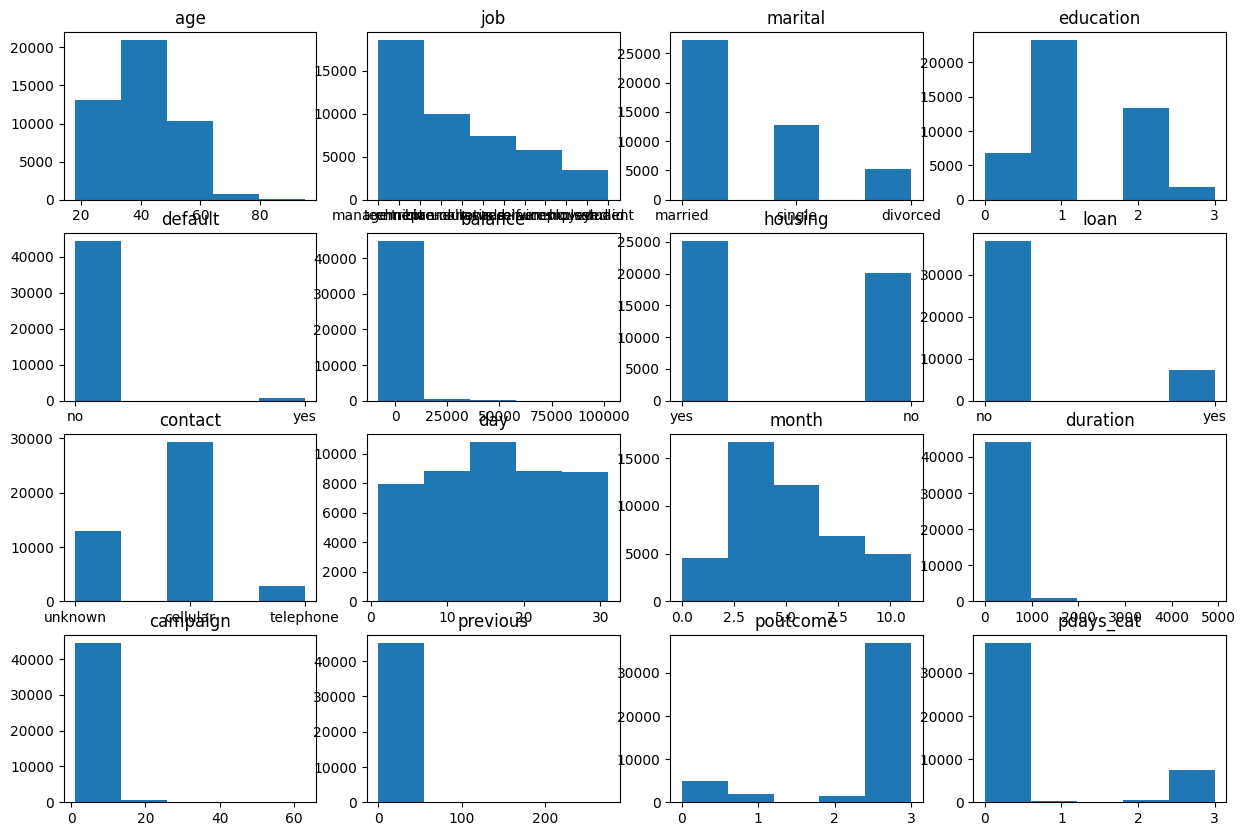

In [24]:
#Check x value distribution
import matplotlib.pyplot as plt

columns = df.drop("target", axis=1).columns

fig,ax = plt.subplots(4,4, figsize=(15, 10))

for i in range(4):
  for j in range(4):
    ax[i,j].hist(df[columns[i*4+j]],bins = 5 )
    ax[i, j].set_title(columns[i*4+j])

plt.show()

In [25]:
# Control correlation with y
corr = df_encoded.corr(numeric_only=True)['target'].sort_values(ascending=False)

print(corr)

target               1.000000
duration             0.394521
pdays_cat            0.161269
previous             0.093236
job_retired          0.079245
job_student          0.076897
education            0.066241
marital_single       0.063526
balance              0.052838
job_management       0.032919
age                  0.025155
job_unemployed       0.020390
month                0.018717
contact_telephone    0.014042
job_self-employed    0.000855
job_unknown          0.000267
job_technician      -0.008970
job_housemaid       -0.015195
job_entrepreneur    -0.019662
default_yes         -0.022419
job_services        -0.027864
day                 -0.028348
marital_married     -0.060260
loan_yes            -0.068185
job_blue-collar     -0.072083
campaign            -0.073172
poutcome            -0.077840
housing_yes         -0.139173
contact_unknown     -0.150935
Name: target, dtype: float64


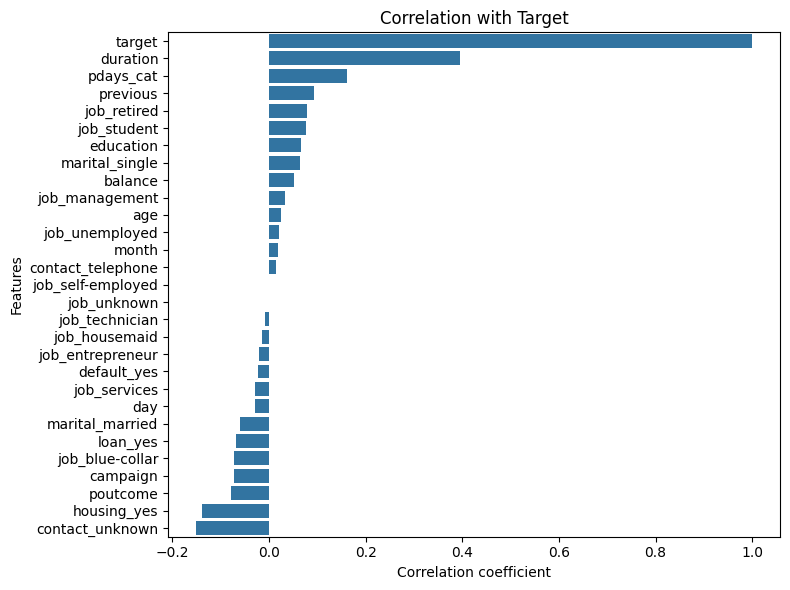

In [26]:
# Visualize
plt.figure(figsize=(8,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title('Correlation with Target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [27]:
# Determine and drop low correlated variables

print(X.shape)
low_corr_cols = corr[abs(corr) <= 0.05].index
X = X.drop(low_corr_cols, axis=1)
print(X.shape)

(45211, 28)
(45211, 15)


In [28]:
corr_matrix = df_encoded.corr(numeric_only=True)
high_corr = []

for i in corr_matrix.columns:
    for j in corr_matrix.columns:
        if i!=j and abs(corr_matrix.loc[i,j]) > 0.8:
            pair = tuple(sorted((i,j)))
            if pair not in high_corr:
                high_corr.append(pair)

print(high_corr)

[('pdays_cat', 'poutcome')]


In [29]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

In [30]:
# Create the model and execute K-Fold CV

tree = DecisionTreeClassifier(random_state=42)

kfold = KFold(shuffle=True, random_state=42)

# Calculate scores
scores = cross_val_score(tree, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Accuracy scores: [0.8487697  0.85208737 0.85581974 0.8555233  0.86520116]
Mean accuracy: 0.855480252265893


In [31]:
# Split test and train data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify=y)

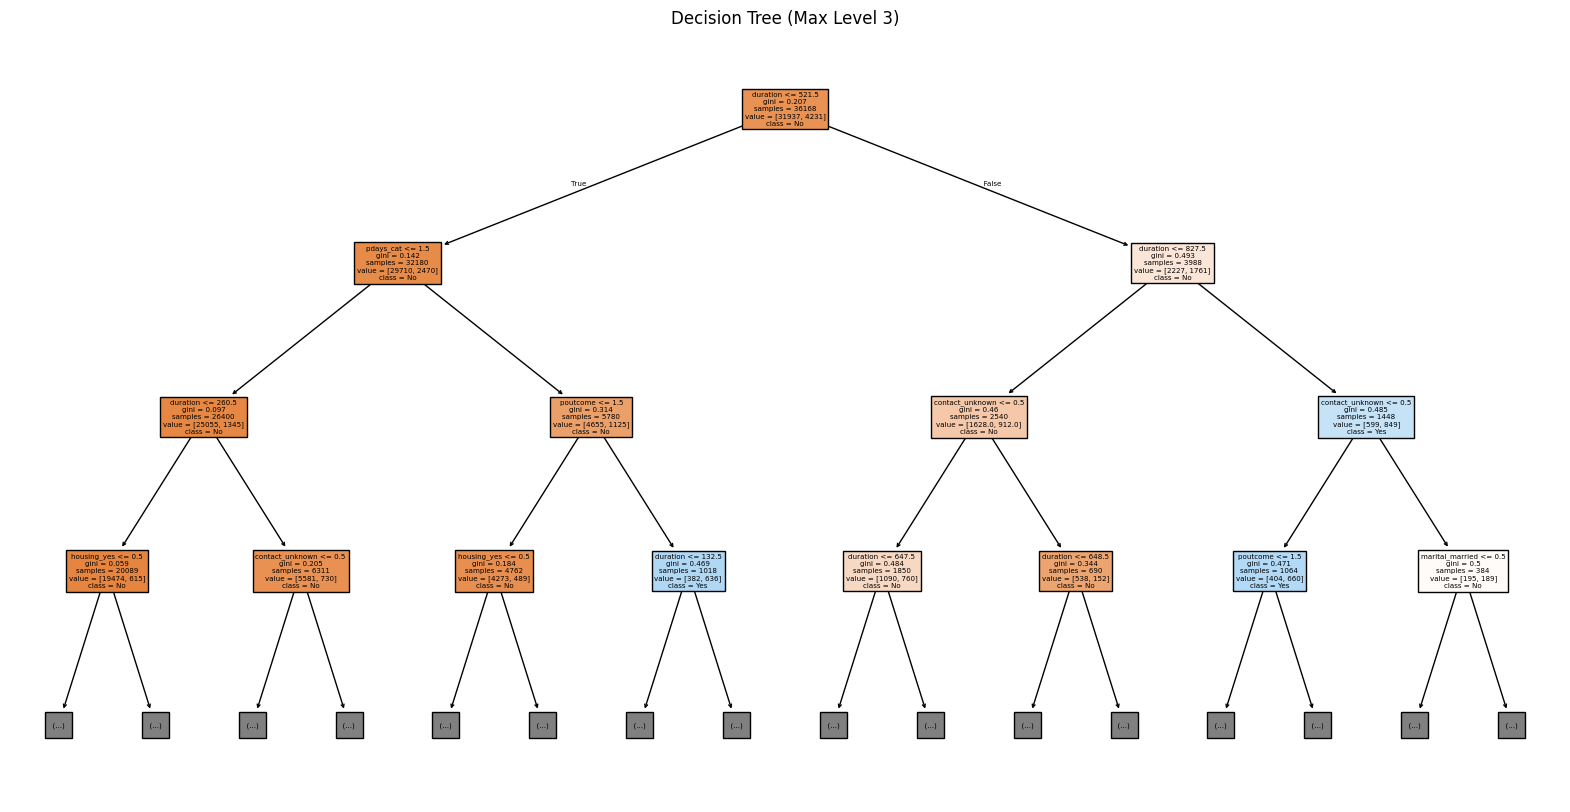

In [32]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Visualize
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_train.columns, class_names=['No', 'Yes'], filled=True, max_depth=3)
plt.title("Decision Tree (Max Level 3)")
plt.show()